In [38]:
import pandas as pd
import pdfplumber
import numpy as np
from utils import *

## Table detection


In [39]:
# pdf_restric

In [40]:
pdf_path = "mcs2024.pdf"

material = 'Sand and Gravel'

p = 159


pdf_restric = {material: [p, p+1]}

selected_p = p

scraping_base = extract_positions_for_elements(pdf_path, pdf_restric)

selected_content = 'content_1'

if selected_content == 'content_1':
    selected_p = p - 1
else:
    selected_p = p

selected_page = scraping_base[material][selected_content]
df = selected_page
page_text_df = selected_page


bounding_box = extract_cols(page_text_df, 'x1', 2)

In [41]:
selected_page

,text,x0,x1,top,doctop,bottom,upright,height,width,direction
0,155,562.651978,575.995977,27.97200,122822.30556,35.97200,True,8.00,13.344000,ltr
1,SAND,205.680000,239.664000,37.45200,122831.78556,49.45200,True,12.00,33.984000,ltr
2,AND,243.000000,269.004000,37.45200,122831.78556,49.45200,True,12.00,26.004000,ltr
3,GRAVEL,272.340000,322.332000,37.45200,122831.78556,49.45200,True,12.00,49.992000,ltr
4,(INDUSTRIAL),325.680000,406.356000,37.45200,122831.78556,49.45200,True,12.00,80.676000,ltr
...,...,...,...,...,...,...,...,...,...,...
342,Mineral,348.244590,383.311584,740.32752,123534.66108,750.34752,True,10.02,35.066994,ltr
343,Commodity,386.046042,441.056844,740.32752,123534.66108,750.34752,True,10.02,55.010802,ltr
344,"Summaries,",443.827374,500.555604,740.32752,123534.66108,750.34752,True,10.02,56.728230,ltr
345,January,503.290062,541.684698,740.32752,123534.66108,750.34752,True,10.02,38.394636,ltr


In [4]:
# pdf_path = "mcs2024.pdf"

# material = 'ABRASIVES'

# p = 34


# pdf_restric = {material: [p, p+1]}

# selected_p = p

# scraping_base = extract_positions_for_elements(pdf_path, pdf_restric)

# selected_content = 'content_2'

# if selected_content == 'content_1':
#     selected_p = p - 1
# else:
#     selected_p = p

# selected_page = scraping_base[material][selected_content]
# df = selected_page
# page_text_df = selected_page


# bounding_box = extract_cols(page_text_df, 'x1', 2)

In [5]:
# Compute margin_top
# refering to previous word (in reading order)
df['margin_top'] = df['bottom'] - df['top'].shift(1)

# Fill the last value of margin_top with 0 or NaN as it has no preceding word
df['margin_top'] = df['margin_top'].fillna(0)

# set margin_top to 0 words in same line
df['margin_top'] = df.apply(lambda row: 0 if row['top'] == df['top'].shift(
    1).loc[row.name] else row['margin_top'], axis=1)

gap_y_df = df[df['margin_top'] > 27]
# Perspective : change threshold using statistic (example : quantile 75 of margin_top)

In [6]:
# bounding_box['max_top_class'] = bounding_box['max_top'].apply(convert_to_class).astype(int)

# # Count occurrences of each value in 'max_top_class'
# class_counts = bounding_box['max_top_class'].value_counts()

# # Filter the dataframe to remove rows where 'max_top_class' exists only once
# bounding_box = bounding_box[bounding_box['max_top_class'].isin(class_counts[class_counts > 1].index)]

In [7]:
# bounding_box['min_bottom_class'] = bounding_box['min_bottom'].apply(convert_to_class).astype(int)

# # Count occurrences of each value in 'max_top_class'
# class_counts = bounding_box['min_bottom_class'].value_counts()

# # Filter the dataframe to remove rows where 'max_top_class' exists only once
# bounding_box = bounding_box[bounding_box['min_bottom_class'].isin(class_counts[class_counts > 1].index)]

In [8]:
bounding_box

,x1,min_bottom,max_top
0,297.71,422.1765,192.64752
1,297.72,444.1965,203.17650
2,351.71,422.1765,214.15650
3,351.72,444.1965,191.37648


In [9]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Assuming bounding_box is already defined as a DataFrame

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

combined_data = np.concatenate(
    (bounding_box[['min_bottom']], bounding_box[['max_top']]), axis=0)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the combined data
normalized_combined_data = scaler.fit_transform(combined_data)

# Split the combined data back into two columns
split_index = len(bounding_box)
normalized_min_bottom = normalized_combined_data[:split_index]
normalized_max_top = normalized_combined_data[split_index:]

# Assign the scaled values back to the DataFrame
bounding_box['min_bottom_normalized'] = np.round(normalized_min_bottom, 0)
bounding_box['max_top_normalized'] = np.round(normalized_max_top, 0)

In [10]:
bounding_box

,x1,min_bottom,max_top,min_bottom_normalized,max_top_normalized
0,297.71,422.1765,192.64752,1.0,0.0
1,297.72,444.1965,203.17650,1.0,0.0
2,351.71,422.1765,214.15650,1.0,0.0
3,351.72,444.1965,191.37648,1.0,0.0


In [11]:
# Group by 'min_bottom_normalized' and 'max_top_normalized'
grouped = bounding_box.groupby(['min_bottom_normalized'])

# Convert each group into a separate dataframe and store them in a list
list_of_dfs = [group.reset_index(drop=True) for _, group in grouped]

list_of_top_bottom_bbox = []
for _, group in grouped:
    if len(group) > 1:
        list_of_top_bottom_bbox.append({
            'bbox_top': float(group['max_top'].min()),
            'bbox_bottom': float(group['min_bottom'].max())
        })

In [12]:
list_of_top_bottom_bbox

[{'bbox_top': 191.37648000000002, 'bbox_bottom': 444.1965}]

In [13]:
list_of_bbox = []
list_of_table_df = []
for top_bottom_bbox in list_of_top_bottom_bbox:
    bbox_top, bbox_bottom = top_bottom_bbox['bbox_top'], top_bottom_bbox['bbox_bottom']

    # Find the nearest 'top' and 'bottom' values in the dataframe
    gap_y_df['top_diff'] = np.abs(gap_y_df['top'] - bbox_top)
    gap_y_df['bottom_diff'] = np.abs(gap_y_df['bottom'] - bbox_bottom)
    gap_y_df['total_diff'] = gap_y_df['top_diff'] + gap_y_df['bottom_diff']

    # Get the row with the minimum total difference
    nearest_row = gap_y_df.loc[gap_y_df['total_diff'].idxmin()]
    nearest_row['top']

    # Calculate the differences between bbox_top and the 'top' values in the dataframe
    gap_y_df['top_diff'] = np.abs(gap_y_df['top'] - bbox_top)

    # Find the row with the minimum 'top_diff' and maximum 'bottom_diff'
    nearest_top_row = gap_y_df.loc[gap_y_df['top_diff'].idxmin()]

    # Filter the dataframe to only include rows with the nearest 'top' and 'bottom' values
    nearest_top_df = gap_y_df[gap_y_df['top'] == nearest_top_row['top']]
    bbox_top_final, bbox_bottom_final = nearest_top_df['top'], bbox_bottom

    padding = 5

    bbox_top_final, bbox_bottom_final = float(
        nearest_top_df['top']), float(bbox_bottom)

    table_df = page_text_df[(page_text_df['top'] >= bbox_top_final - padding)
                            & (page_text_df['bottom'] <= bbox_bottom_final + padding)]

    bbox_start, bbox_end = float(
        table_df['x0'].min()), float(table_df['x1'].max())

    list_of_bbox.append({
        'bbox_top': bbox_top_final,
        'bbox_bottom': bbox_bottom_final,
        'bbox_start': bbox_start,
        'bbox_end': bbox_end
    })
    list_of_table_df.append(table_df)

C:\Users\DataScience\AppData\Local\Temp\ipykernel_75748\1143877381.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gap_y_df['top_diff'] = np.abs(gap_y_df['top'] - bbox_top)
C:\Users\DataScience\AppData\Local\Temp\ipykernel_75748\1143877381.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gap_y_df['bottom_diff'] = np.abs(gap_y_df['bottom'] - bbox_bottom)
C:\Users\DataScience\AppData\Local\Temp\ipykernel_75748\1143877381.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [14]:
list_of_bbox

[{'bbox_top': 181.66751999999997,
  'bbox_bottom': 444.1965,
  'bbox_start': 44.94,
  'bbox_end': 526.3559879999999}]

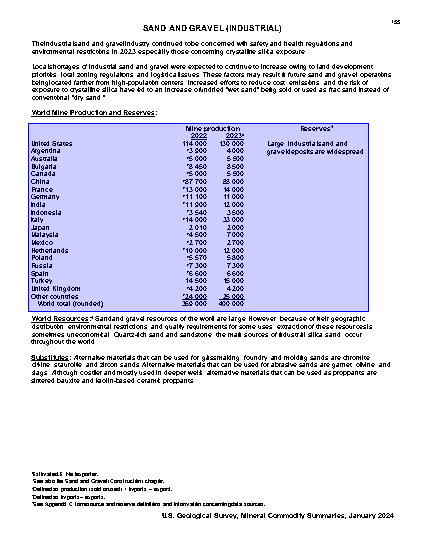

In [15]:
with pdfplumber.open("mcs2024.pdf") as pdf:
    im = pdf.pages[selected_p].to_image(resolution=50)

# Draw a rectangle using the bounding box coordinates
border_color = "blue"

for bbox in list_of_bbox:
    # Draw a rectangle using the bounding box coordinates with specified colors
    im.draw_rect([bbox['bbox_start'] - padding, bbox['bbox_top'] - padding, bbox['bbox_end'] + padding, bbox['bbox_bottom'] + padding],
                 stroke=border_color, stroke_width=1)

im

In [16]:
# STOP HERE

## Table to Dataframe


In [17]:
import re

# Remove special characters from 'text'
table_df['text'] = table_df['text'].apply(lambda x: re.sub(r'\W+', '', x))

C:\Users\DataScience\AppData\Local\Temp\ipykernel_75748\1481100593.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_df['text'] = table_df['text'].apply(lambda x: re.sub(r'\W+', '', x))


In [19]:
# filter indices (smaller than most used text height)

mode_height = table_df['height'].mode()[0]

table_df = table_df[table_df['height'] > round(mode_height, 0)]

In [24]:
comb_table_df = complexe_word(list_of_table_df[0], 0)   # until here it's good

In [28]:
groups = []

# Iterate through each combination of rows to form groups
for i, row1 in comb_table_df.iterrows():
    added_to_any_group = False
    for group in groups:
        if any(belongs_to_same_group(row1, comb_table_df.iloc[j]) for j in group):
            group.append(i)
            added_to_any_group = True
    if not added_to_any_group:
        groups.append([i])

# Add group labels to the dataframe
comb_table_df['group'] = -1
group_label = 0
for group in groups:
    for index in group:
        if comb_table_df.at[index, 'group'] == -1:  # Assign a new group label if not already assigned
            comb_table_df.at[index, 'group'] = group_label
    group_label += 1

In [30]:
comb_table_df['group'].unique().tolist()

[0, 1, 2]

In [31]:
comb_table_df[comb_table_df['group'] == 2]['x0'].min()

45.0

In [32]:
unique_groups = comb_table_df['group'].unique()

dfs = []

# Loop over the unique values and create a DataFrame for each group
for group in unique_groups:
    df_group = comb_table_df[comb_table_df['group'] == group]
    dfs.append(df_group)


In [33]:
group_counter = 1
to_merge = []

for df in dfs[:]:
    # Check if there are any duplicated 'bottom' values
    if df['bottom'].duplicated().any():
        unique_x1 = df['x1'].unique()
        for x1 in unique_x1:
            df.loc[df['x1'] == x1, 'TEST'] = group_counter
            group_counter += 1
    else:
        to_merge.append(df)

dfs = [df for df in dfs if id(df) not in [id(d) for d in to_merge]]
new_dfs = []

for df in dfs[:]:
    unique_tests = df['TEST'].dropna().unique()  # Get unique TEST values, ignoring NaNs
    for test_value in unique_tests:
        temp_df = df[df['TEST'] == test_value].copy()
        if len(temp_df) > 1:  # Check if this subset has repeated values
            temp_df = temp_df.drop(columns=['TEST'])  
            new_dfs.append(temp_df)
            df.drop(temp_df.index, inplace=True)  # Remove these rows from the original DataFrame
# Append the new DataFrames to the original list

    if not df.empty:
        new_dfs = [pd.concat([new_df, df], ignore_index=True) for new_df in new_dfs]

dfs =  to_merge + new_dfs

# for df in dfs[:]:
    # make each elements with same TEST value on a new df, append it to dfs if this is repeated at least once, and eraze it from the old df

C:\Users\DataScience\AppData\Local\Temp\ipykernel_75748\3857257472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['x1'] == x1, 'TEST'] = group_counter
C:\Users\DataScience\AppData\Local\Temp\ipykernel_75748\3857257472.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(temp_df.index, inplace=True)  # Remove these rows from the original DataFrame
C:\Users\DataScience\AppData\Local\Temp\ipykernel_75748\3857257472.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

In [34]:
df_min_x0_tuples = []

# Loop over the unique values and create a DataFrame for each group with its corresponding min_x0
for df in dfs:
  # print(df)
  min_x0 = df['x0'].min()
  df_min_x0_tuples.append((df, min_x0))

# Sort the list of tuples by min_x0
df_min_x0_tuples_sorted = sorted(df_min_x0_tuples, key=lambda x: x[1])

# Extract the sorted DataFrames into a list
dfs = [df_tuple[0] for df_tuple in df_min_x0_tuples_sorted]

In [36]:
merged_df = merge_list_of_dataframes(dfs)

merged_df.columns

Index(['text', 'bottom', 'text_1', 'text_2', 'text_3'], dtype='object')

In [37]:
merged_df.sort_values('bottom')[['text', 'text_1', 'text_2', 'text_3']]

,text,text_1,text_2,text_3
23,None,Mine production,Mine production,Reserves4
22,None,2022,2023e,None
0,United States,114000,130000,Large Industrial sand and
1,Argentina,e3900,4000,gravel deposits are widespread
2,Australia,e5000,5500,None
3,Bulgaria,e8450,8500,None
4,Canada,e5000,5500,None
5,China,e87700,88000,None
6,France,e13000,14000,None
7,Germany,e11100,11000,None
